In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## Dataset Exploration

In [2]:
data = pd.read_csv('itsm.csv')

In [3]:
data.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,...,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4.0,0.601292,...,NaN,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1.0,SD0000007,2.0,NaN,NaN
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3.0,0.415050,...,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1.0,SD0000011,1.0,NaN,NaN
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NaN,0.517551,...,NaN,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1.0,SD0000017,NaN,NaN,NaN
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4.0,0.642927,...,NaN,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1.0,SD0000025,NaN,NaN,NaN
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4.0,0.345258,...,NaN,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1.0,SD0000029,NaN,NaN,NaN


In [4]:
data.CI_Cat.fillna('application',inplace=True)
data.CI_Subcat.fillna('One View Reporting',inplace=True)

In [5]:
data.Urgency.replace('5 - Very Low',5,inplace=True)
data.Urgency=data.Urgency.astype(np.int64)

In [6]:
data.Priority.fillna(data.Urgency,inplace=True)
data.Priority= data.Priority.astype('int32')

In [7]:
data.Impact.replace('NS',np.nan,inplace=True)
data.Impact.fillna(data.Urgency,inplace=True)
data.Impact = data.Impact.astype('int32')

In [8]:
new_data=data[['CI_Name','CI_Cat','CI_Subcat','Category','Priority']]

new_data.replace({'CI_Cat':{'applicationcomponent':'computer',
                           'displaydevice':'hardware',
                           'officeelectronics':'hardware',
                           'networkcomponents':'hardware',
                           'Phone':'hardware',
                           'database':'storage',
                           }
                 },
                 inplace=True
                )

In [9]:
new_data.CI_Cat.unique()

array(['subapplication', 'application', 'computer', 'hardware',
       'software', 'storage'], dtype=object)

# 3. Auto Tag tickets with right priority and the right dapartment

## Predict the right departments

### Getting the data

In [170]:
data3 = new_data.copy()
data3.drop(['Priority','CI_Name'],axis=1,inplace=True)

In [171]:
data3.head()

,CI_Cat,CI_Subcat,Category
0,subapplication,Web Based Application,incident
1,application,Web Based Application,incident
2,application,Desktop Application,request for information
3,application,Web Based Application,incident
4,application,Web Based Application,incident


In [165]:
data3.isnull().sum()

CI_Name      0
CI_Cat       0
CI_Subcat    0
Category     0
dtype: int64

## Splitting into X and Y

In [166]:
X = data3.drop(['CI_Cat'],axis=1)
Y = data3['CI_Cat']

In [167]:
X.head()

,CI_Name,CI_Subcat,Category
0,SUB000508,Web Based Application,incident
1,WBA000124,Web Based Application,incident
2,DTA000024,Desktop Application,request for information
3,WBA000124,Web Based Application,incident
4,WBA000124,Web Based Application,incident


In [168]:
Y.head()

0    subapplication
1       application
2       application
3       application
4       application
Name: CI_Cat, dtype: object

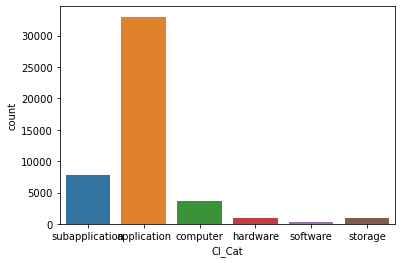

In [169]:
sns.countplot(new_data.CI_Cat)
plt.show()

### Encoding

In [142]:
# Encoding the categorical data

ord_enc = OrdinalEncoder()
lab_enc =LabelEncoder()

cat_col = X.select_dtypes(include=object).columns
X[cat_col]=ord_enc.fit_transform(X[cat_col])

Y=pd.DataFrame(lab_enc.fit_transform(Y),columns=Y.columns.tolist())


In [143]:
X.head()

,CI_Subcat,Category
0,58.0,1.0
1,58.0,1.0
2,10.0,3.0
3,58.0,1.0
4,58.0,1.0


In [144]:
Y

,CI_Cat
0,5
1,0
2,0
3,0
4,0
...,...
46601,0
46602,0
46603,1
46604,0


### EDA

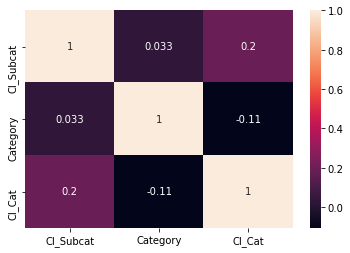

In [145]:
D = X.join(Y)
sns.heatmap(D.corr(),annot=True)
plt.show()

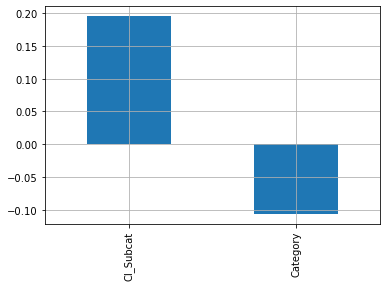

In [146]:
X.corrwith(Y.CI_Cat).plot(kind='bar',grid=True)
plt.show()

### Train-Test-Split

# prepare the data

In [147]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20,random_state=100)

X_train.shape,X_test.shape

((37284, 2), (9322, 2))

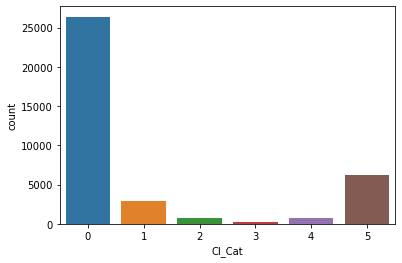

In [148]:
sns.countplot(Y_train.CI_Cat)
plt.show()

In [149]:
Y_train.value_counts()

CI_Cat
0         26372
5          6238
1          2945
2           735
4           730
3           264
dtype: int64

### Applying SMOTE

In [150]:
from imblearn.over_sampling import SMOTE

In [151]:
oversample = SMOTE(random_state=42)
X_train_over,Y_train_over = oversample.fit_resample(X_train.astype(float),Y_train)

In [152]:
Y_train_over.shape

(158232, 1)

In [153]:
Y_train_over.value_counts()

CI_Cat
5         26372
4         26372
3         26372
2         26372
1         26372
0         26372
dtype: int64

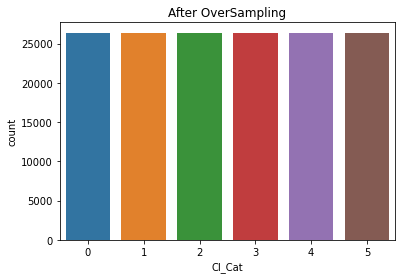

In [154]:
sns.countplot(Y_train_over.CI_Cat)
plt.title('After OverSampling')
plt.show()

## Model Initialization and Training

### RandomForest Classifier

In [155]:
model_rfc = RandomForestClassifier(random_state=100).fit(X_train_over,Y_train_over)
Y_rfc = model_rfc.predict(X_test)

print('%% The score for {} is {} %%'.format(model_rfc,model_rfc.score(X,Y)))

print('\nConfusion Matrix :')
print('----------------\n')
print(confusion_matrix(Y_test,Y_rfc))
print('\nClassification Report:')
print('---------------------\n\n')
print(classification_report(Y_test,Y_rfc))

%% The score for RandomForestClassifier(random_state=100) is 0.7856928292494528 %%

Confusion Matrix :
----------------

[[4921    0    0    0    0 1718]
 [   0  702    0    1    0    0]
 [   0    0  180    0    0    0]
 [   0    0    0   69    0    0]
 [   0    0    1    0  186    0]
 [ 320    0    0    0    0 1224]]

Classification Report:
---------------------


              precision    recall  f1-score   support

           0       0.94      0.74      0.83      6639
           1       1.00      1.00      1.00       703
           2       0.99      1.00      1.00       180
           3       0.99      1.00      0.99        69
           4       1.00      0.99      1.00       187
           5       0.42      0.79      0.55      1544

    accuracy                           0.78      9322
   macro avg       0.89      0.92      0.89      9322
weighted avg       0.86      0.78      0.80      9322



In [156]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,Y_rfc)

0.7811628405921476

### XGBClassifier

In [32]:
model_xgb = XGBClassifier(verbosity=0,random_state=100).fit(X_train_over,Y_train_over)
Y_xgb = model_xgb.predict(X_test)

#print('%% The score for {} is {} %%'.format(model_xgb,model_xgb.score(X,Y)))

print('\nConfusion Matrix :')
print('----------------\n')
print(confusion_matrix(Y_test,Y_xgb))
print('\nClassification Report:')
print('---------------------\n\n')
print(classification_report(Y_test,Y_xgb))


Confusion Matrix :
----------------

[[4921    0    0    0    0 1718]
 [   0  702    0    1    0    0]
 [   0    0  180    0    0    0]
 [   0    0    0   69    0    0]
 [   0    0    1    0  186    0]
 [ 320    0    0    0    0 1224]]

Classification Report:
---------------------


              precision    recall  f1-score   support

           0       0.94      0.74      0.83      6639
           1       1.00      1.00      1.00       703
           2       0.99      1.00      1.00       180
           3       0.99      1.00      0.99        69
           4       1.00      0.99      1.00       187
           5       0.42      0.79      0.55      1544

    accuracy                           0.78      9322
   macro avg       0.89      0.92      0.89      9322
weighted avg       0.86      0.78      0.80      9322



### KNN

In [33]:
model_knn = KNeighborsClassifier().fit(X_train_over,Y_train_over)
Y_knn = model_knn.predict(X_test)

#print('%% The score of {} is {} %%'.format(model_knn,model_knn.score(X,Y)))

print('\nConfusion Matrix :\n----------------\n\n',confusion_matrix(Y_test,Y_knn))
print('\nClassification Report:\n---------------------\n\n',classification_report(Y_test,Y_knn))


Confusion Matrix :
----------------

 [[4909    0    0    0    0 1730]
 [   0  702    0    1    0    0]
 [   0    0  179    0    1    0]
 [   0    0    0   69    0    0]
 [   0    0    2    0  185    0]
 [ 314    0    0    0    0 1230]]

Classification Report:
---------------------

               precision    recall  f1-score   support

           0       0.94      0.74      0.83      6639
           1       1.00      1.00      1.00       703
           2       0.99      0.99      0.99       180
           3       0.99      1.00      0.99        69
           4       0.99      0.99      0.99       187
           5       0.42      0.80      0.55      1544

    accuracy                           0.78      9322
   macro avg       0.89      0.92      0.89      9322
weighted avg       0.86      0.78      0.80      9322



## Model Selection using CV

* RandomForest Classifier
* XGBoost classifier
* KNN

In [34]:
from sklearn.model_selection import cross_val_score

In [35]:
####===================== Random Forest======================#####

RF_3 = RandomForestClassifier(random_state=100)
RF_3.fit(X,Y)

RFC3_acc = cross_val_score(estimator=RF_3,X=X,y=Y,cv= 8,scoring='accuracy')
rfc=[RFC3_acc.mean(), RFC3_acc.std()]

#####========================== XGBoost =============================####

XGB_3 = XGBClassifier()
XGB_3.fit(X,Y)

XGB3_acc = cross_val_score(estimator= XGB_3,X= X,y=Y,cv=8,scoring='accuracy')
xgb = [XGB3_acc.mean(), XGB3_acc.std()]

#####=================================KNN=============================####

KNC_3 = KNeighborsClassifier()
KNC_3.fit(X,Y)

KNC3_acc = cross_val_score(estimator=KNC_3,X=X,y=Y ,cv=8,scoring='accuracy')
kn=[KNC3_acc.mean(), KNC3_acc.std()]

####===========Summary of all the mean and standard deviations of the accuracies============######

cvs = {'model':['Random','XGB','KNN'],
      'Accuracy mean':[(rfc[0]),(xgb[0]),(kn[0])],
      'Accuracy std':[rfc[1],xgb[1],kn[1]]
      }

pd.DataFrame(cvs)

## Selected model 

* The basic model of RandomForestClassifier yielded better score.
* For higher accuracy hypertuning of RFC has to be done

### Hypertune XGBClassifier

In [181]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


def evaluate(model, test_features, test_labels):
    '''
    Returns the accuracy of the model.
    Also calculates the average error of the estimator model passed.
    
    '''
    predictions = model.predict(test_features)
    errors = abs(predictions-test_labels).astype(float)
    accuracy = accuracy_score(test_labels,predictions)
    mean_error = np.mean(errors)
    print('=='*10,' Model Performance ','=='*10)
    print('Average Error:{}'.format(mean_error))
    print('Accuracy = {:0.4f}.'.format(accuracy))
    
    return accuracy



def improvement(base,tuned):
    '''
    Returns the improvement in accuracy from different models
    
    '''
    impr =  100 * ((tuned - base) / base)
    return impr




#### Randomized Search CV

In [162]:
n_estimators = [ x for x in np.arange(50,100,10)]
max_depth = [x for x in np.arange(2,15,2)]
min_samples_split = [x for x in np.arange(1,10,1)]
max_features = ['auto','log2',None]
random_state=[x for x in np.arange(0,500,10)]

param_random = {
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'max_features':max_features,
    'random_state':random_state
}

# RandomSearch Training

RFC1 = RandomForestClassifier()

# Random search of parameters

RFC_random = RandomizedSearchCV(RFC1, param_random , n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1,scoring='accuracy',return_train_score=True)
RFC_random.fit(X_train_over,Y_train_over)
print('The best parameters from randomsearch :',RFC_random.best_params_)

# Initialising and fitting the base model

base_model = RandomForestClassifier()
base_model.fit(X_train_over, Y_train_over)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
The best parameters from randomsearch : {'random_state': 410, 'n_estimators': 80, 'min_samples_split': 9, 'max_features': None, 'max_depth': 14}


RandomForestClassifier()

In [183]:

base_accuracy = evaluate(base_model,X_test, Y_test.values)

# Evaluate the best found estimator

best_random = RFC_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, Y_test.values)

print('Improvement of {:0.2f}% in accuracy using Randomized Search for RFC from base model.'.format( improvement(base_accuracy,random_accuracy)))

====================  Model Performance  ====================
Average Error:2.0714659215561704
Accuracy = 0.7812.
====================  Model Performance  ====================
Average Error:2.0714659215561704
Accuracy = 0.7812.
Improvement of 0.00% in accuracy using Randomized Search for RFC from base model.


In [185]:
# Create the parameter grid based on the results of random search 

param_grids = {
    'n_estimators':[50,150],
    'max_depth': [10,12,16],
    'min_samples_split':[5,6,7,10],
    'random_state':[40],
    'max_features':[None]
}


# Create a based model
RFC2 = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RFC2, param_grid = param_grids,cv = 5, n_jobs = -1, verbose = 2,scoring= 'accuracy',return_train_score=True)

# Fit the grid search to the data
grid_search.fit(X_train_over, Y_train_over)





print('The best parameters from gridsearchcv : ',grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, Y_test.values)

print('Improvement of {:0.2f}% in accuracy using Grid search CV for RFC from base model.'.format( improvement(base_accuracy,grid_accuracy)))

print('Improvement of {:0.2f}% in accuracy from Randomized to Grid search CV for RFC.'.format( improvement(random_accuracy,grid_accuracy)))

print('The best estimator : ',best_grid)





Fitting 5 folds for each of 24 candidates, totalling 120 fits
The best parameters from gridsearchcv :  {'max_depth': 16, 'max_features': None, 'min_samples_split': 10, 'n_estimators': 150, 'random_state': 40}
====================  Model Performance  ====================
Average Error:2.0714659215561704
Accuracy = 0.7812.
Improvement of 0.00% in accuracy using Grid search CV for RFC from base model.
Improvement of 0.00% in accuracy from Randomized to Grid search CV for RFC.
The best estimator :  RandomForestClassifier(max_depth=16, max_features=None, min_samples_split=10,
                       n_estimators=150, random_state=40)


## Final model for Prediction of Department

In [ ]:
best_model3= model_knn
best_model3.fit(X_train_over,Y_train_over)
Y_predict = best_model3.predict(X_test)

print(classification_report(Y_test,Y_predict))